In [1]:
import os
import numpy as np
import pandas as pd
from analysis import *

import random

from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
import fastcluster


from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
from hdbscan import HDBSCAN

from pyclustering.cluster.hsyncnet import *
from pyclustering.cluster.kmeans import *
from pyclustering.cluster.kmedians import *
from pyclustering.cluster.elbow import elbow

from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np

import seaborn as sns

In [2]:
NUM_CORES = 8
SUBSET_SIZE = 100000

## 1: Database Loading, Visualization, and Pre-Processing

### 1.1: Dataframe Creation
Create dataframes to store the SDSS MOC4 asteroid database, as well as Carvano's Taxonomy database of classified SDSS MOC4 asteroids.

In [3]:
sdss_df = import_sdss ("%s/Databases/SDSSMOC4/data/sdssmocadr4.tab" % os.getcwd())

# Drop information not relevant to this problem, along with the SMOC_ID, which just indicates
# an SDSS observation; one asteroid can have multiple SMOC_ID, so it isn't a useful identifier.
sdss_df.drop(labels=['OBJ_ID_RUN', 'OBJ_ID_COL', 'OBJ_ID_FIELD',
                     'OBJ_ID_OBJ', 'ROWC', 'COLC', 'JD_ZERO', 'RA',
                     'DEC', 'LAMBDA', 'BETA', 'PHI', 'VMU', 'VMU_ERROR',
                     'VNU', 'VNU_ERROR', 'VLAMBDA', 'VBETA', 'IDFLAG',
                     'RA_COMPUTED', 'DEC_COMPUTED', 'V_MAG_COMPUTED',
                     'R_DIST', 'G_DIST', 'OSC_CAT_ID', 'ARC',
                     'EPOCH_OSC', 'A_OSC', 'E_OSC', 'I_OSC', 'LON_OSC',
                     'AP_OSC', 'M_OSC', 'PROP_CAT_ID', 'A_PROP',
                     'E_PROP', 'SIN_I_PROP', 'B_MAG', 'H', 'G',
                     'A_MAG', 'A_ERR', 'SMOC_ID', 'PHASE', 'D_COUNTER', 
                     'TOTAL_D_COUNT'],
                     axis=1, inplace=True)

In [4]:
tax_df = import_tax("%s/Databases/SDSSTaxonomy/data/sdsstax_ast_table.tab" % os.getcwd())
tax_df.drop(labels=['AST_NAME', 'SCORE', 'NCLASS', 'METHOD', 'BAD',
                    'SEQUENCE', 'PROPER_SEMIMAJOR_AXIS',
                    'PROPER_ECCENTRICITY',
                    'SINE_OF_PROPER_INCLINATION',
                    'OSC_SEMIMAJOR_AXIS', 'OSC_ECCENTRICITY',
                    'OSC_INCLINATION'],
                     axis=1, inplace=True)

In [5]:
wave_mags = ["U_MAG", "G_MAG", "R_MAG", "I_MAG", "Z_MAG"]
wave_mags = wave_mags[2:]

wave_errs = ["U_ERR", "G_ERR", "R_ERR", "I_ERR", "Z_ERR"]

# Ensure data integrity. Every observation MUST have a U, G, R, I, and Z value, and associated error.
sdss_df.dropna(subset=wave_mags + wave_errs, inplace=True)

In [6]:
wave_mags

['R_MAG', 'I_MAG', 'Z_MAG']

In [7]:
merged = merge(sdss_df, tax_df, ["PROV_ID", "AST_NUMBER"])
merged.reset_index(drop=True, inplace=True)

In [10]:
def reflect(x, y):
    return -2.5*(np.log10(x) - np.log10(y))

merged["COLOR_U"] = reflect(merged["U_MAG"], merged["V_MAG"])
merged["COLOR_G"] = reflect(merged["G_MAG"], merged["V_MAG"])
merged["COLOR_R"] = reflect(merged["R_MAG"], merged["V_MAG"])
merged["COLOR_I"] = reflect(merged["I_MAG"], merged["V_MAG"])
merged["COLOR_Z"] = reflect(merged["Z_MAG"], merged["V_MAG"])

def grad(c1, c2, c1_base, c2_base):
    return -0.4*((c2 - c1) / (c2_base - c1_base))

merged["G_REFL"] = grad(merged["COLOR_G"], merged["COLOR_U"], 0.354, 0.477)
merged["R_REFL"] = grad(merged["COLOR_U"], merged["COLOR_R"], 0.477, 0.623)
merged["I_REFL"] = grad(merged["COLOR_R"], merged["COLOR_I"], 0.623, 0.763)
merged["Z_REFL"] = grad(merged["COLOR_I"], merged["COLOR_Z"], 0.763, 0.913)


wave_mags = ["G_REFL", "R_REFL", "I_REFL", "Z_REFL"]

In [41]:
merged["COLOR_U"] = merged["U_MAG"] - merged["G_MAG"] - 1.32
merged["COLOR_G"] = merged["G_MAG"] - merged["R_MAG"] - 0.45
merged["COLOR_R"] = merged["R_MAG"] - merged["I_MAG"] - 0.10
merged["COLOR_I"] = merged["I_MAG"] - merged["Z_MAG"] - 0.04

merged["G_REFL"] = grad(merged["COLOR_G"], merged["COLOR_U"], 0.354, 0.477)
merged["R_REFL"] = grad(merged["COLOR_U"], merged["COLOR_R"], 0.477, 0.623)
merged["I_REFL"] = grad(merged["COLOR_R"], merged["COLOR_I"], 0.623, 0.763)
wave_mags = ["G_REFL", "R_REFL", "I_REFL"]

In [42]:
merged

,U_MAG,U_ERR,G_MAG,G_ERR,R_MAG,R_ERR,I_MAG,I_ERR,Z_MAG,Z_ERR,...,COLOR_R,COLOR_I,COLOR_Z,G_REFL,R_REFL,I_REFL,Z_REFL,ELBOW_CLASSIFICATION,KMEANS_CLASSIFICATION,AGGLOMERATIVE_CLASSIFICATION
0,21.81,0.20,20.32,0.04,19.77,0.02,19.56,0.03,19.44,0.14,...,1.100000e-01,8.000000e-02,0.030291,-0.227642,0.164384,8.571429e-02,-0.017817,0.0,0.0,4.0
1,22.04,0.23,20.36,0.03,19.82,0.03,19.66,0.03,19.44,0.11,...,6.000000e-02,1.800000e-01,0.032462,-0.878049,0.821918,-3.428571e-01,-0.032582,0.0,0.0,4.0
2,19.69,0.03,17.91,0.02,17.32,0.01,17.10,0.02,17.05,0.03,...,1.200000e-01,1.000000e-02,0.032000,-1.040650,0.931507,3.142857e-01,-0.008478,0.0,7.0,7.0
3,21.83,0.16,19.82,0.02,19.16,0.02,18.94,0.02,19.02,0.06,...,1.200000e-01,-1.200000e-01,0.023156,-1.560976,1.561644,6.857143e-01,0.012204,0.0,7.0,7.0
4,22.40,0.24,20.40,0.02,19.73,0.02,19.47,0.03,19.76,0.10,...,1.600000e-01,-3.300000e-01,0.013650,-1.495935,1.424658,1.400000e+00,0.042807,0.0,7.0,7.0
5,21.96,0.17,20.30,0.03,19.95,0.03,19.73,0.03,19.71,0.10,...,1.200000e-01,-2.000000e-02,0.020193,-1.430894,0.602740,4.000000e-01,-0.002936,0.0,0.0,4.0
6,21.33,0.14,20.00,0.02,19.49,0.02,19.34,0.02,19.33,0.05,...,5.000000e-02,-3.000000e-02,0.020035,0.162602,-0.109589,2.285714e-01,-0.001497,0.0,12.0,4.0
7,21.54,0.12,19.66,0.02,19.09,0.02,18.96,0.03,18.85,0.05,...,3.000000e-02,7.000000e-02,0.026740,-1.430894,1.452055,-1.142857e-01,-0.016847,0.0,7.0,7.0
8,20.74,0.06,18.96,0.02,18.29,0.01,18.05,0.02,18.12,0.03,...,1.400000e-01,-1.100000e-01,0.026634,-0.780488,0.876712,7.142857e-01,0.011207,0.0,7.0,7.0
9,20.75,0.19,18.99,0.02,18.32,0.01,18.13,0.02,18.19,0.04,...,9.000000e-02,-1.000000e-01,0.023617,-0.715447,0.958904,5.428571e-01,0.009566,0.0,7.0,7.0


In [43]:
training_data = merged[wave_mags].values[:SUBSET_SIZE]

### 1.2: Visualization
We use the T-distributed Stochastic Neighbor Embedding (TSNE) dimensionality reduction algorithm to represent our 5D data as a 2D graph, as PCA seems overdone.

In [44]:
# This takes a while.
merged_projection = TSNE(n_jobs=NUM_CORES).fit_transform(training_data)

... And then we do PCA anyway.

In [45]:
merged_pca_projection = PCA(n_components=2).fit_transform(training_data)

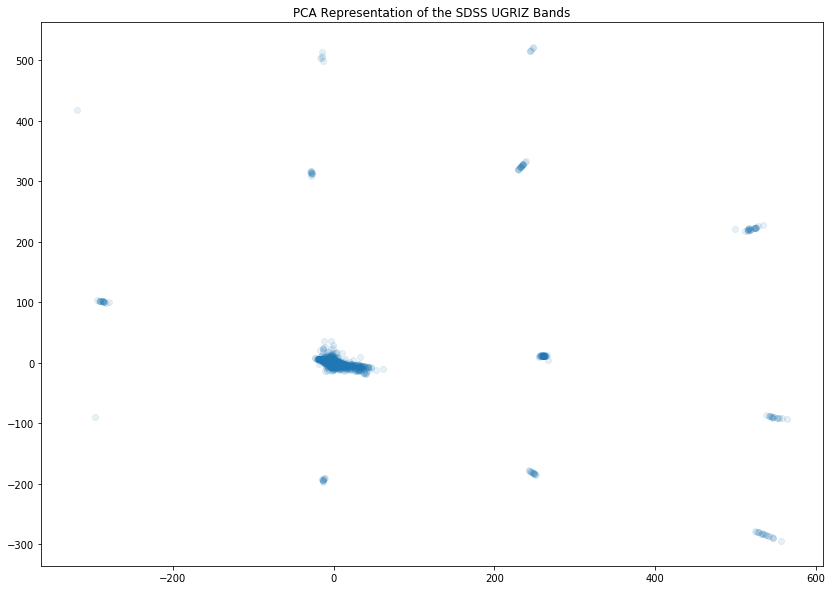

In [46]:
# PCA plot
plt.figure(figsize=(14, 10))
plt.scatter(merged_pca_projection[:,0],
            merged_pca_projection[:,1], alpha=0.1)
plt.title("PCA Representation of the SDSS UGRIZ Bands")
plt.show()

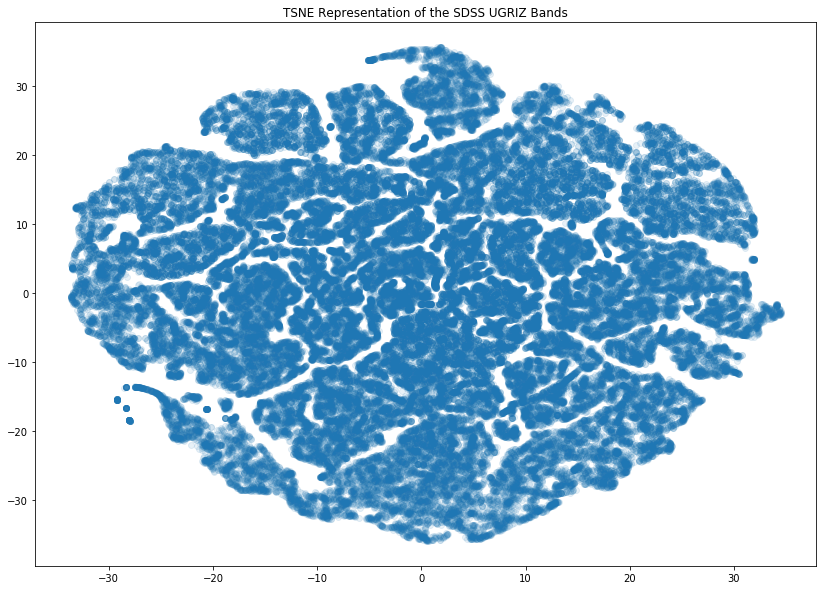

In [47]:
# TSNE plot
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, alpha=0.1)
plt.title("TSNE Representation of the SDSS UGRIZ Bands")
plt.show()

In [48]:
# Calculate colorings for Carvano's classification
unique_tax = merged["CLASSIFICATION"][:SUBSET_SIZE].unique()
tax_color_dict = dict(zip(unique_tax, list(range(len(unique_tax)))))

color_palette = sns.color_palette('Paired', len(unique_tax))

cluster_colors = [color_palette[tax_color_dict[x]] if tax_color_dict[x] >= 0
                  else (0.5, 0.5, 0.5)
                  for x in merged["CLASSIFICATION"][:SUBSET_SIZE]]

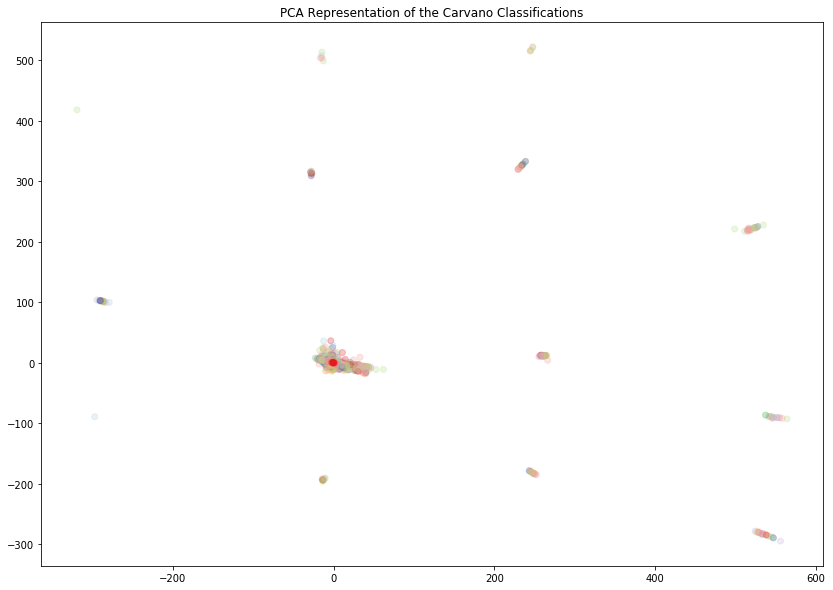

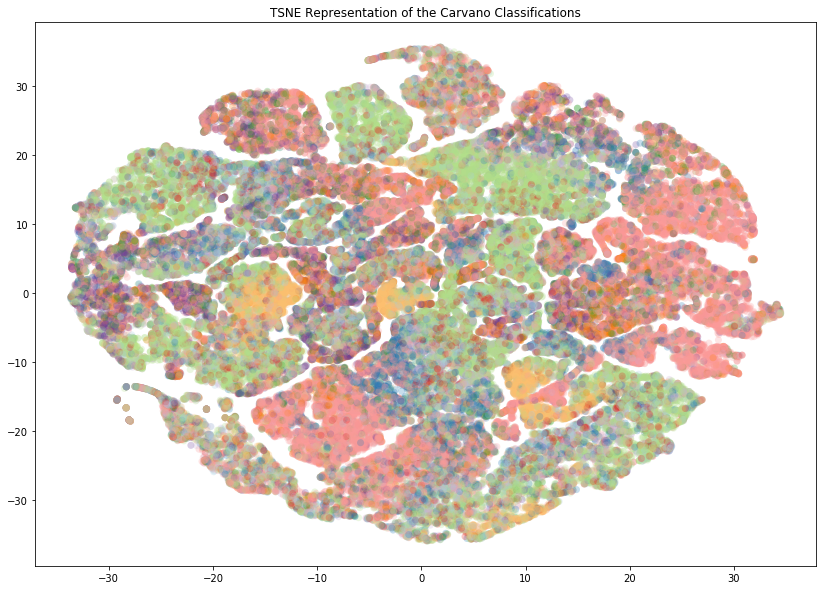

In [49]:
# Plot PCA and TSNE

# PCA plot
plt.figure(figsize=(14, 10))
plt.scatter(merged_pca_projection[:,0],
            merged_pca_projection[:,1],
            c=cluster_colors, alpha=0.25)
plt.title("PCA Representation of the Carvano Classifications")
plt.show()

# TSNE plot
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, s=50, linewidth=0,
            c=cluster_colors, alpha=0.25)
plt.title("TSNE Representation of the Carvano Classifications")
plt.show()

## 2: Elbow Method
Manual computation of clusters, in the form of the equation

$$
Elbow_{k} = \frac{\left ( y_{0} - y_{1} \right )x_{k} + \left ( x_{1} - x_{0} \right )y_{k} + \left ( x_{0}y_{1} - x_{1}y_{0} \right )}{\sqrt{\left ( x_{1} - x_{0} \right )^{2} + \left ( y_{1} - y_{0} \right )^{2}}}
$$

given a kmin-point ($x_0$, $y_0$) the kmax-point ($x_1$, $y_1$), the value $x_k$, the amount of clusters, and $y_k$, the within-cluster error.

In [50]:
# Initialize the Elbox algorithm testing 1 to 20 clusters.
kmin, kmax = 1, 20
elbow_instance = elbow(training_data, kmin, kmax)

In [51]:
# process input data and obtain results of analysis
elbow_instance.process()
amount_clusters = elbow_instance.get_amount()

In [52]:
amount_clusters

6

In [53]:
# perform cluster analysis using K-Means algorithm
centers = kmeans_plusplus_initializer(training_data, amount_clusters).initialize()
kmeans_instance = kmeans(training_data, centers)
kmeans_instance.process()

In [54]:
# obtain clustering results and visualize them
elbow_clusters = kmeans_instance.get_clusters()
elbow_centers = kmeans_instance.get_centers()

In [55]:
# Now, compare against Carvano.
apply_classification(merged, elbow_clusters, "ELBOW_CLASSIFICATION")

In [56]:
color_palette = sns.color_palette('Paired', len(elbow_clusters))
cluster_colors = [(0, 0, 0)] * SUBSET_SIZE

for idx, arr in enumerate(elbow_clusters):
    for sub_index in arr:
        cluster_colors[sub_index] = color_palette[idx]

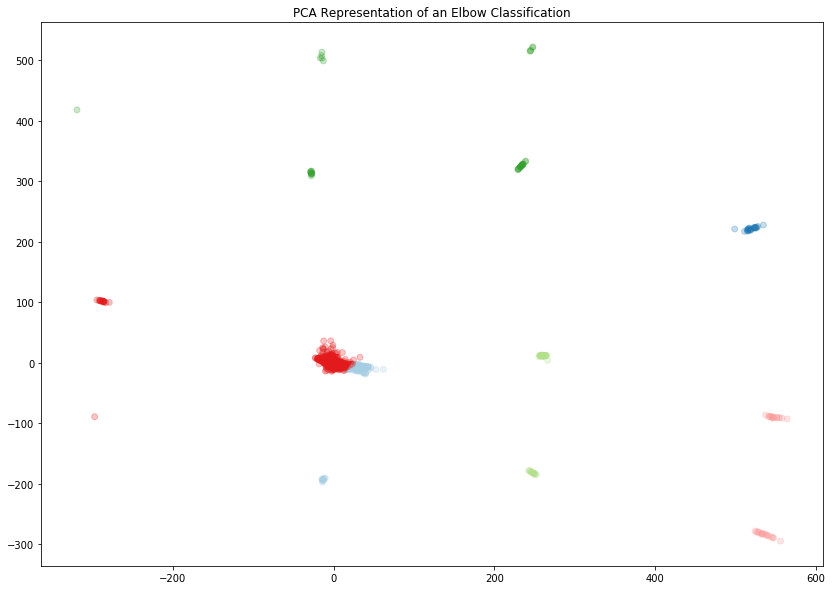

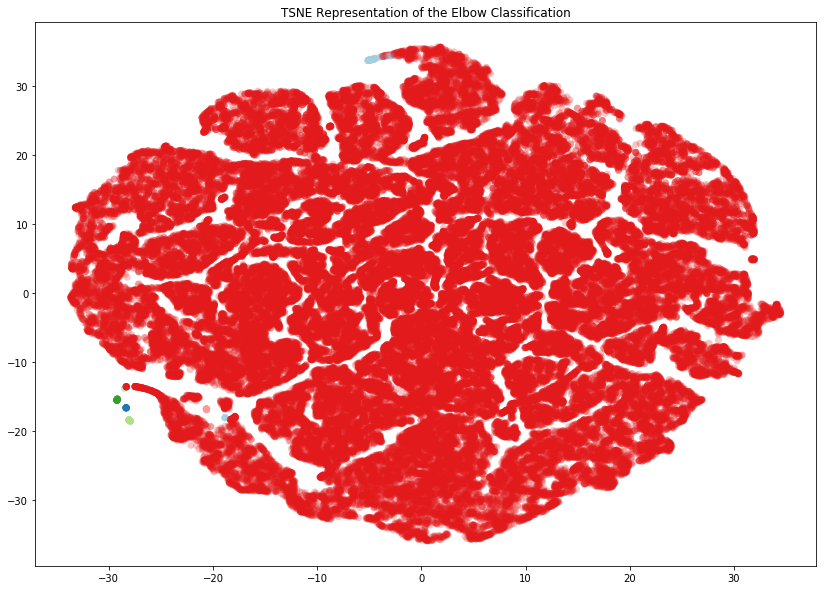

In [57]:
# PCA plot
plt.figure(figsize=(14, 10))
plt.scatter(merged_pca_projection[:,0],
            merged_pca_projection[:,1],
            c=cluster_colors, alpha=0.25)
plt.title("PCA Representation of an Elbow Classification")
plt.show()

# TSNE plot
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, s=50, linewidth=0,
            c=cluster_colors, alpha=0.25)
plt.title("TSNE Representation of the Elbow Classification")
plt.show()

## 3: K-Means++
Now, we do a graphical analysis to determine the number of clusters.

In [ ]:
# Use k-means++ to guess centers
run_bound = 25
run_max = 10

all_args = [(training_data, i) for i in range(1, run_bound)]

with Pool(8) as p:
    all_output = [p.starmap(k_means_pp, all_args) for i in range(run_max)]

In [ ]:
fig = plt.figure(figsize=(14,10))
for i in range(run_max):
    # Get the full resample i's array of errors.
    err = [all_output[i][j][1] for j in range(run_bound - 1)]
    plt.plot(range(len(err) + 1), [None,] + err)
    
ax = fig.gca()
ax.set_xticks(numpy.arange(0, 25, 1))
plt.title("K-Means++ Cost vs. Clusters")
plt.ylabel("Sum of Squared Error")
plt.xlabel("Number of Clusters")
plt.grid()
plt.show()

In [58]:
graphical_clusters = 16

In [59]:
# perform cluster analysis using K-Means algorithm
centers = kmeans_plusplus_initializer(training_data, graphical_clusters).initialize()
kmeans_instance = kmeans(training_data, centers)
kmeans_instance.process()

In [60]:
# obtain clustering results and visualize them
kmeans_clusters = kmeans_instance.get_clusters()
kmeans_centers = kmeans_instance.get_centers()

In [61]:
# Now, compare against Carvano.
apply_classification(merged, kmeans_clusters, "KMEANS_CLASSIFICATION")

In [62]:
color_palette = sns.color_palette('Paired', len(kmeans_clusters))
cluster_colors = [(0, 0, 0)] * SUBSET_SIZE

for idx, arr in enumerate(kmeans_clusters):
    for sub_index in arr:
        cluster_colors[sub_index] = color_palette[idx]

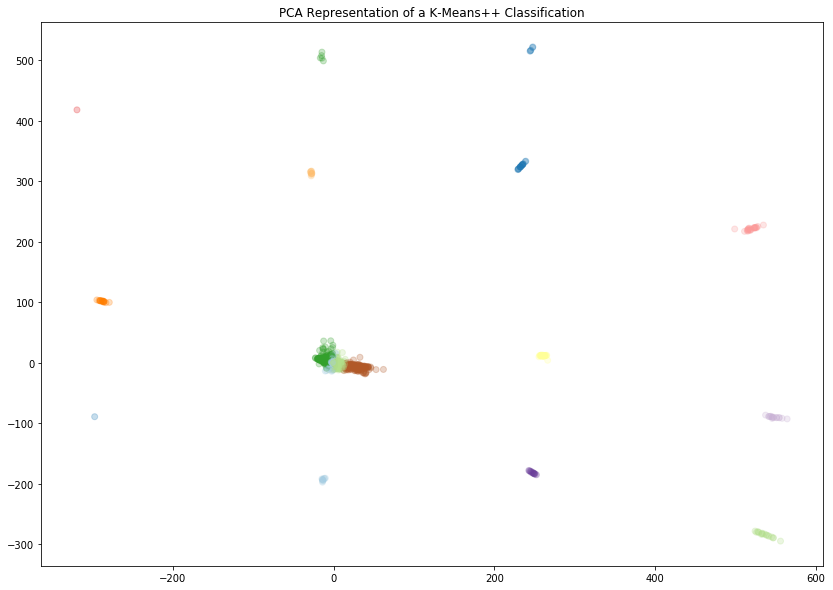

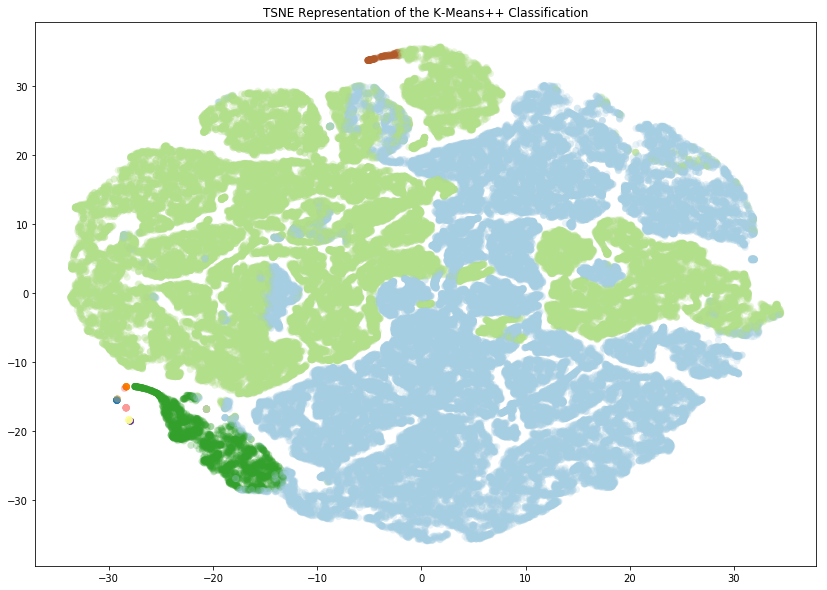

In [63]:
# PCA plot
plt.figure(figsize=(14, 10))
plt.scatter(merged_pca_projection[:,0],
            merged_pca_projection[:,1],
            c=cluster_colors, alpha=0.25)
plt.title("PCA Representation of a K-Means++ Classification")
plt.show()

# TSNE plot
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, s=50, linewidth=0,
            c=cluster_colors, alpha=0.25)
plt.title("TSNE Representation of the K-Means++ Classification")
plt.show()

## 4: HDBSCAN

In [66]:
# Create HDBSCAN algorithm instance for cluster analysis
# chebyshev
# cityblock
# infinity
# l1
hdbscan_instance = HDBSCAN().fit(training_data)

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:334: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:334: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:334: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:334: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


In [67]:
hdbscan_instance.labels_.max()

3320

In [68]:
hdbscan_clusters = [np.where(hdbscan_instance.labels_ == i)[0] for i in range(-1, hdbscan_instance.labels_.max())]

In [69]:
# Now, compare against Carvano.
apply_classification(merged, hdbscan_clusters, "HDBSCAN_CLASSIFICATION")

In [70]:
color_palette = sns.color_palette('Paired', len(elbow_clusters))
cluster_colors = [(0, 0, 0)] * SUBSET_SIZE

for idx, arr in enumerate(elbow_clusters):
    for sub_index in arr:
        cluster_colors[sub_index] = color_palette[idx]

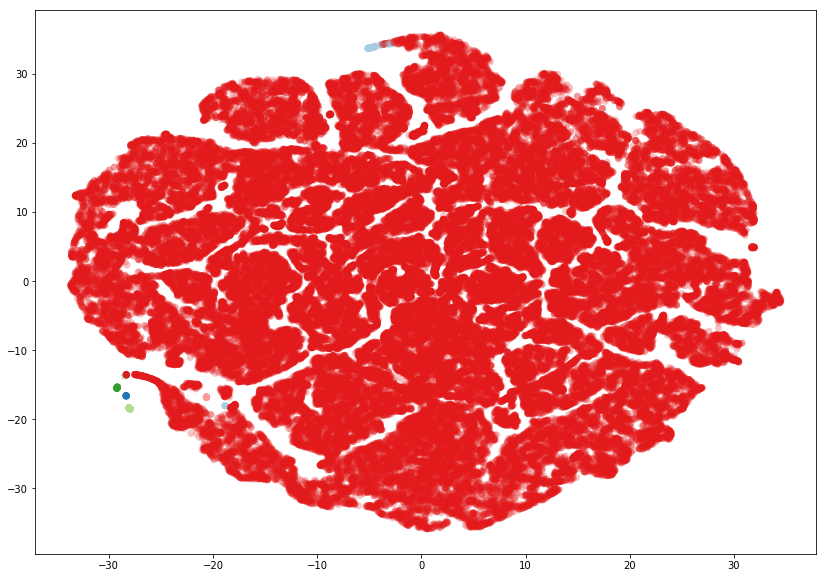

In [71]:
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

## 5: Agglomerative

In [64]:
# Get an idea of dendogram relations
examination_data = random.sample(list(training_data), 25)
links = fastcluster.linkage_vector(examination_data, method='ward')

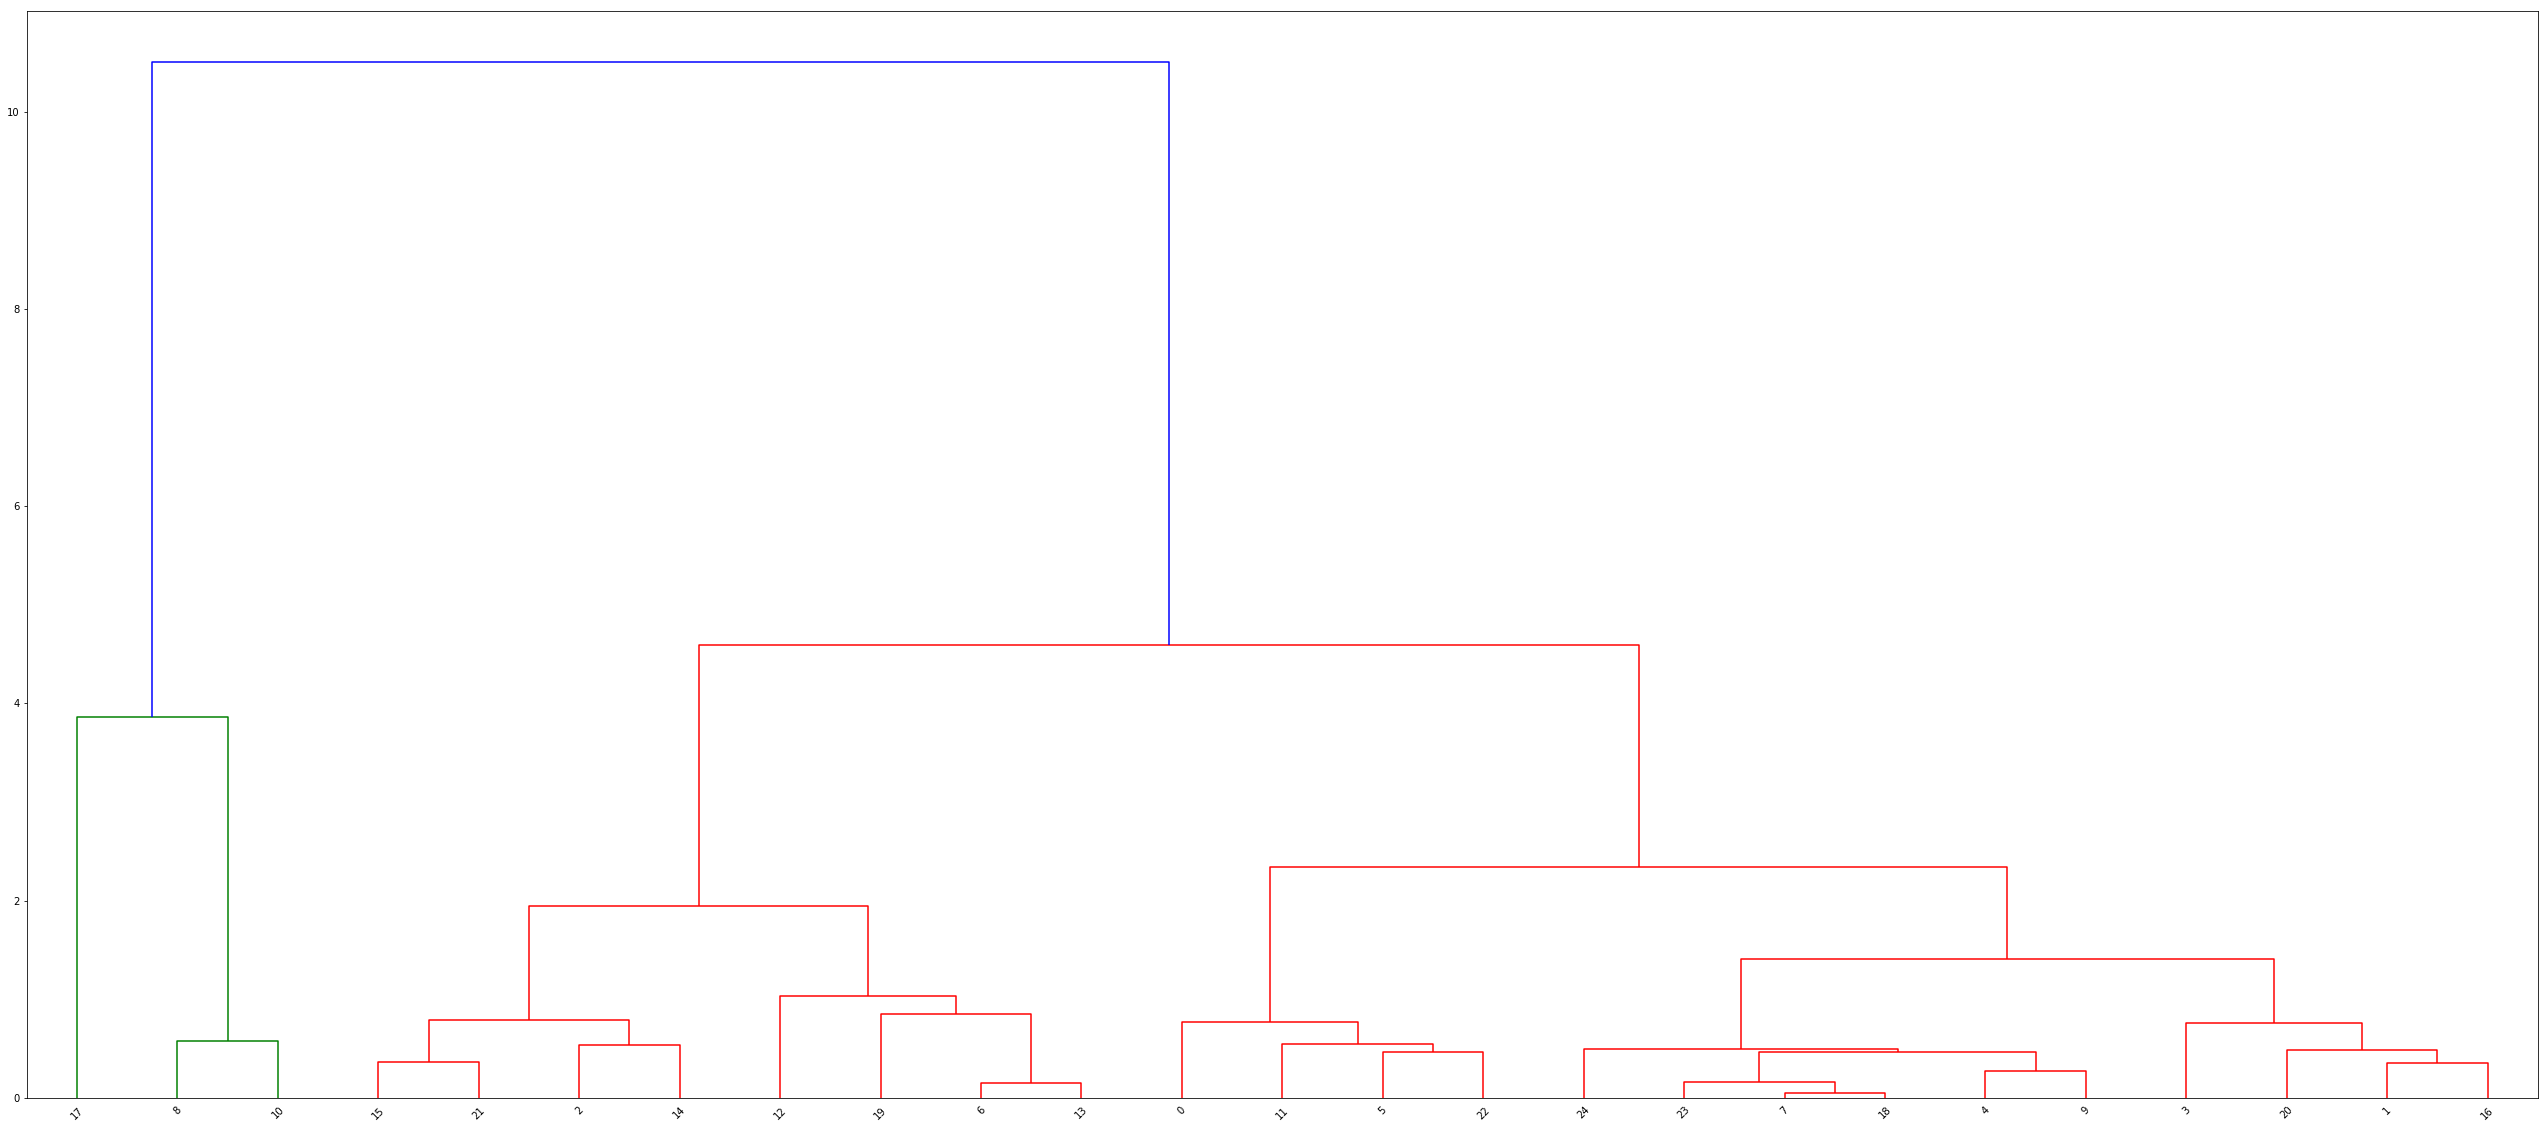

In [65]:
fig = plt.figure(figsize=(45, 20))
dn = dendrogram(links)
plt.show()

In [33]:
links = fastcluster.linkage_vector(training_data, method='ward')

In [34]:
#clusters = fcluster(links, 300, criterion='distance')
clusters = fcluster(links, 16, criterion='maxclust')
np.max(clusters)

16

In [35]:
agglomerative_clusters = np.array([np.where(clusters == i)[0] for i in range(np.max(clusters))])

In [36]:
# Now, compare against Carvano.
apply_classification(merged, agglomerative_clusters, "AGGLOMERATIVE_CLASSIFICATION")

In [37]:
color_palette = sns.color_palette('Paired', len(agglomerative_clusters))
cluster_colors = [(0, 0, 0)] * SUBSET_SIZE

for idx, arr in enumerate(agglomerative_clusters):
    for sub_index in arr:
        cluster_colors[sub_index] = color_palette[idx]

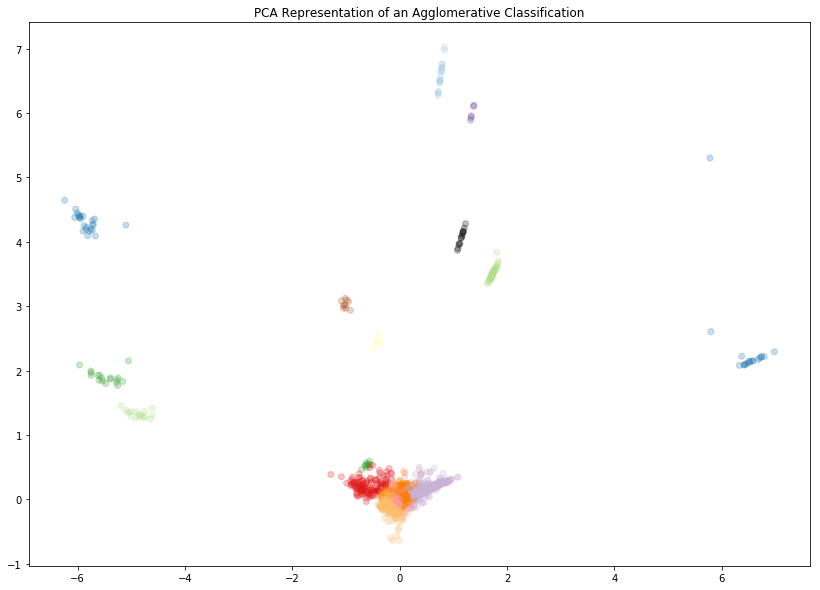

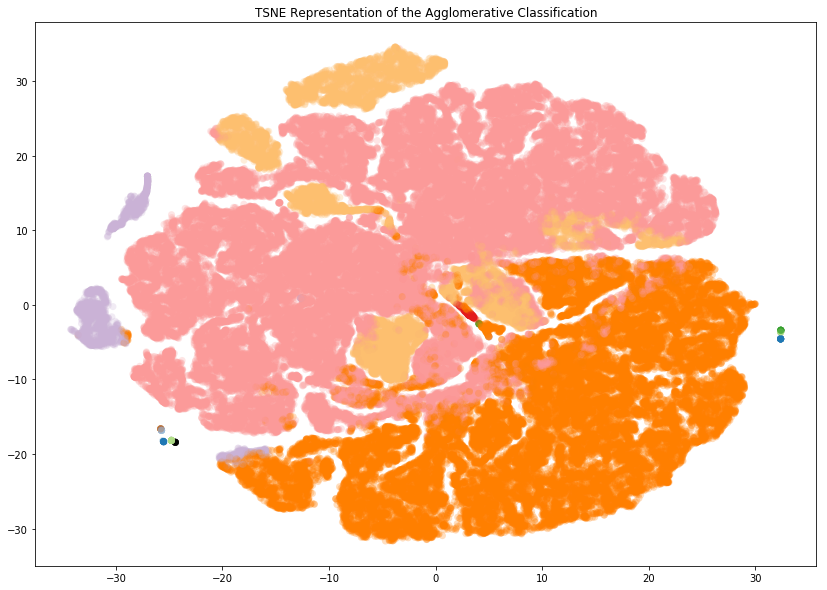

In [38]:
# PCA plot
plt.figure(figsize=(14, 10))
plt.scatter(merged_pca_projection[:,0],
            merged_pca_projection[:,1],
            c=cluster_colors, alpha=0.25)
plt.title("PCA Representation of an Agglomerative Classification")
plt.show()

# TSNE plot
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, s=50, linewidth=0,
            c=cluster_colors, alpha=0.25)
plt.title("TSNE Representation of the Agglomerative Classification")
plt.show()